In [440]:
#%%
# This script implements the algorithm for Public Storage data as how 
# it can make a decision as whether to expand, contract or buy properties

__author__ = "Minakshi Mukherjee"


import seaborn as sns
import numpy as np 
import pandas as pd 
import pymysql
import matplotlib.pyplot as plt
import time
import warnings
import importlib
import os
from datetime import datetime, date, timedelta
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, precision_recall_curve, auc,roc_auc_score
from matplotlib import pyplot as plt, style
from tabulate import tabulate
from time import gmtime, strftime
from statsmodels.tsa.stattools import adfuller
from scipy import linalg
warnings.filterwarnings("ignore")


# It sets up the maximum display if output is viewed in notebook
def setup():
    pd.set_option('display.max_rows', 3000)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    sns.set_context("paper", font_scale=1.3)
    sns.set_style('white')
    
# This Function ingests and preprocess the Public Storage locations csv data 
# The output is a dataframe
def ingest_ps_data(file):
    df = pd.read_csv(file, header=0, squeeze=True)
    df = df.rename(columns={'Owner/Operator, Franchise': 'Franchise'})
    df= df.applymap(lambda s:s.upper() if type(s) == str else s)
    df = df[df.Franchise.str.contains('PUBLIC STORAGE', na=False, regex=False)]  # assumption: only keep Public Storage
    df = df[df['ST'] == 'CA'] # assumption: only keep California
    print("**** data  has***",df.shape[0], " rows and ",df.shape[1], "  columns ", "******")
    
    return df   

# Top 20  ZIP codes with highest number of PS within a city
def city_zip_plot(df):
    # Top 20 EV ZIP codes with highest number of EV owners
    city_zip_df = df[['CTY','Zip']].groupby(['CTY','Zip'])['Zip'].agg(['count'])
    city_zip_df = city_zip_df.sort_values('count', ascending=False).reset_index()
    data = city_zip_df[:20]
    plt.figure(figsize = (15,8))
#     plt.rcParams["figure.figsize"] = (15,8)
    sns.set_style("darkgrid")
    plt.tick_params(labelsize = 15)
    sns.barplot(x = data['Zip'],y = data['count'], \
                 order=data.sort_values('count').Zip, dodge=False, hue=data['CTY'])
    plt.ylabel('Counts',fontsize = 15)
    plt.xlabel('Zip code',fontsize = 15)
    plt.tight_layout()  
    plt.xticks(rotation=80)
    plt.show()
    plt.close() 

# Sq Ft of PS in different markets
def area_cty_plot(df):
    f, ax = plt.subplots(figsize=(15, 8))
    sns.set_style("darkgrid")
    sns.despine(f, left=True, bottom=True)
    plt.tick_params(labelsize = 13)
    sns.scatterplot(x="CTY", y="Area",
                    hue="Market", 
                    linewidth=0,
                    data=df, ax=ax)
    plt.xticks(rotation=88)
    plt.ylabel('Area( Sq Ft)',fontsize = 13)
    plt.xlabel('City',fontsize = 13)
    plt.setp(ax.get_legend().get_texts(), fontsize='13') # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize='13') # for legend title
    plt.show()

# This Function ingests and preprocess other datafiles
# The output is a dataframe
def ingest_other_data(file):
    df = pd.read_csv(file, header=0, squeeze=True)
    df= df.applymap(lambda s:s.upper() if type(s) == str else s)
    print("**** data  has***",df.shape[0], " rows and ",df.shape[1], "  columns ", "******")
    
    return df   

# This Function loads the final data for ML into an numpy array
# The output is a numpy array of features for Gaussian Expectation Maximization algorithm
def load_gmm_dataset(csv_path):
    with open(csv_path, 'r') as csv_fh:
        headers = csv_fh.readline().strip().split(',')
        
    x_cols = [i for i in range(len(headers))]
    
    x = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols, dtype=float)
    
    return x


# This Function implements the Expectation step for Gaussian Expectation Maximization algorithm
# The output is a numpy array of probability weights
def e_step(x, w, phi, mu, sigma):
    n, d = x.shape
    k = len(mu)
    
    for i in range(n):
        for j in range(k):
            w[i, j] = p_x_given_z(x[i], mu[j], sigma[j]) * phi[j]
            
    w /= np.sum(w, axis=1, keepdims = True)
    
    return w

# This Function implements posterior probability  for Gaussian Expectation Maximization algorithm
# The output is the probability value
def p_x_given_z(x, mu, sigma):
    d = len(x)
    assert d == len(mu) and sigma.shape == (d, d), 'Shape mismatch'
    
    c = 1. / ((2. * np.pi) ** (d / 2) * np.sqrt(np.linalg.det(sigma)))
    x_minus_mu = x - mu
    sigma_inv = linalg.pinv(sigma)  # Do pseudo inverse
    p_val = c * np.exp(-.5 * x_minus_mu.dot(sigma_inv).dot(x_minus_mu.T))
    
    return p_val

# This Function implements the Maximization step for Gaussian Expectation Maximization algorithm
# The output contains the optimumm value of the parameters phi, mu (multivariate Gaussian mean),
# sigma(multivariate Gaussian covariance matrix)
def m_step(x, w, mu, sigma):
    n, d = x.shape
    k = len(mu)
    
    phi = np.mean(w, axis=0)
    
    for j in range(k):
        w_j = w[:, j:j+1]
        mu[j] = np.sum(w_j * x, axis =0) / np.sum(w_j)
        
        sigma[j] = np.zeros_like(sigma[j])
        for i in range(n):
            x_minus_mu = x[i] - mu[j]
            sigma[j] += w[i, j] * np.outer(x_minus_mu, x_minus_mu)
            
        sigma[j] /= np.sum(w_j)
        
    return phi, mu, sigma

# This Function calculates the log likelihood FN for Gaussian Expectation Maximization algorithm
# The output is the value of the log likelihood Fn
def log_likelihood(x, phi, mu, sigma, z=None):
    n, d = x.shape
    k = len(phi)
    ll = 0
    for i in range(n):
        p_x = 0.
        for j in range(k):
            p_x += p_x_given_z(x[i], mu[j], sigma[j]) * phi[j]
        ll += np.log(p_x)
        
    return ll

# This Function implements the main algorithm for Gaussian Expectation Maximization algorithm
# using e-step and m-step 
def run_em(x, w, phi, mu, sigma):
    
    eps = 1e-3
    max_iter = 30  # assumption: For simplicity only allow a maximum of 30 iterations
    
    # stop when absolute change in log-likelihood is < eps
    it = 0
    ll = prev_ll = None
    while it < max_iter and ( prev_ll is None or np.abs(ll - prev_ll) >= eps):
        w = e_step(x, w, phi, mu, sigma)
        
        phi, mu, sigma = m_step(x, w, mu, sigma)
        
        prev_ll = ll
        ll = log_likelihood(x, phi, mu, sigma)
        it += 1
        print('[iter: {:03d}, log-likelihood: {:.4f}]'.format(it, ll))
        
    return w 

# Read and Pre-Process Data

In [383]:
    setup()
    ######################## INGEST DATA PROVIDED BY PUBLIC STORAGE ##################################
    ps_loc = ingest_ps_data('property_locations.csv')
    
    ######################## INGEST ADDITIONAl DATA ##################################
    ps_data = ingest_other_data('psdata.csv')
    
    ps_data[['race_encode','race']] = ps_data.race.str.split(".",expand=True)
    ps_data[['edu_encode','education']] = ps_data.education.str.split(".",expand=True)
    
    ps_join = pd.merge(ps_loc, ps_data, on='Zip', how='inner')
    
    ######################## INGEST ADDITIONAl DATA ##################################
    ps_metro = ingest_other_data('metro_unemp_new.csv')
    ps_metro[['CTY','ST']] = ps_metro.Metropolitan_area.str.split(",",expand=True)
    ps_metro = ps_metro[ps_metro.ST.str.contains('CA', na=False, regex=False)]
    ps_metro = ps_metro[['CTY','Feb_2021_Unemp_rate']]
    
    ######################## PREPARE JOINED DATAFRAME ##################################
    ps_join = pd.merge(ps_join,ps_metro, on='CTY', how='left')
    
    ps_join

**** data  has*** 454  rows and  8   columns  ******
**** data  has*** 3000  rows and  10   columns  ******
**** data  has*** 5  rows and  2   columns  ******


Market       Franchise                      ADDRESS  \
0           BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
1           BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
2           BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
3           BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
4           BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
5           BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
6           BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
7           BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
8           BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
9           BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
10          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
11          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
12          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
13          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
14          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
15          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
16          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
17          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
18          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
19          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
20          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
21          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
22          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
23          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
24          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
25          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
26          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
27          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
28          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
29          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
30          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
31          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
32          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
33          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
34          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
35          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
36          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
37          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
38          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
39          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
40          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
41          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
42          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
43          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
44          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
45          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
46          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
47          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
48          BAY AREA - EAST BAY  PUBLIC STORAGE          1551 MACARTHUR BLVD   
49          BAY AREA - EA

# Exploratory Data Analysis(EDA)

In [399]:
ps_loc

Market                 Franchise  \
2100                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2101                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2102                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2103                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2104                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2105                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2106                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2107                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2108                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2109                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2110                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2111                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2112                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2113                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2114                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2115                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2116                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2117                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2118                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2119                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2120                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2121                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2122                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2123                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2124                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2125                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2126                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2127                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2128                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2129                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2130                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2131                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2132                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2133                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2134                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2135                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2136                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2137                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2138                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2139                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2140                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2141                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2142                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2143                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2144                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2145                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2146                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2147                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2148                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2149                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2150                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2151                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2152                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2153                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2154                   BAY AREA - EAST BAY            PUBLIC STORAGE   
2155

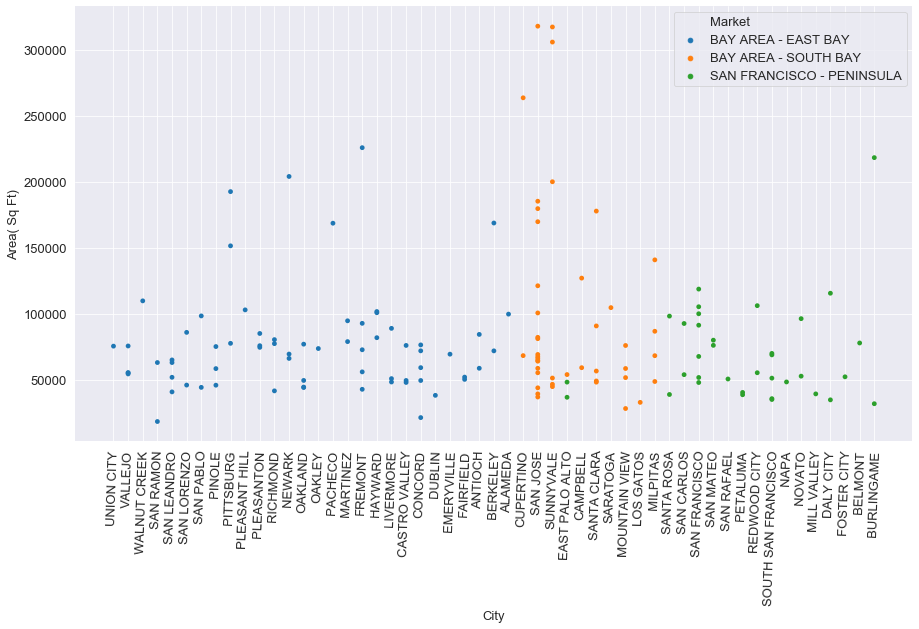

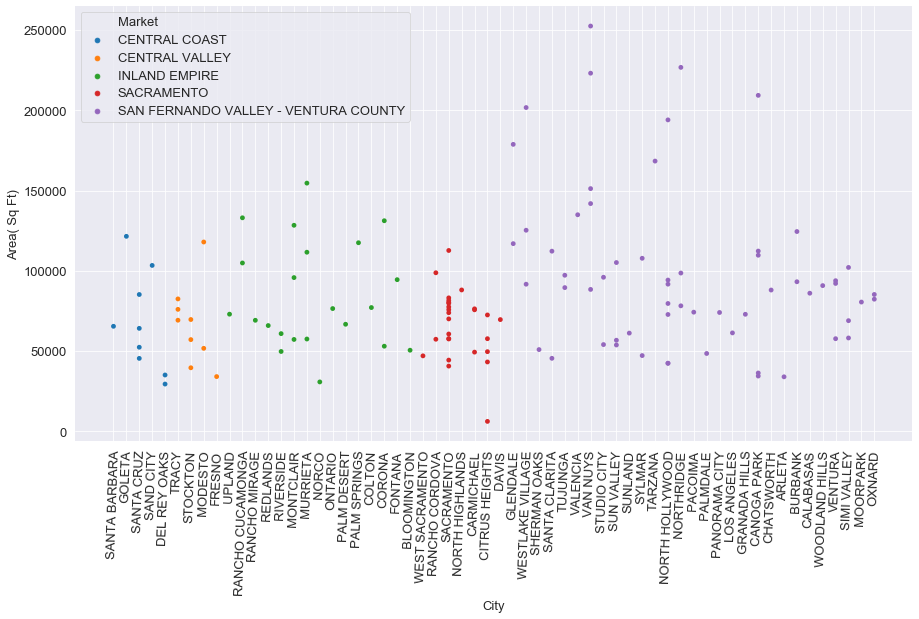

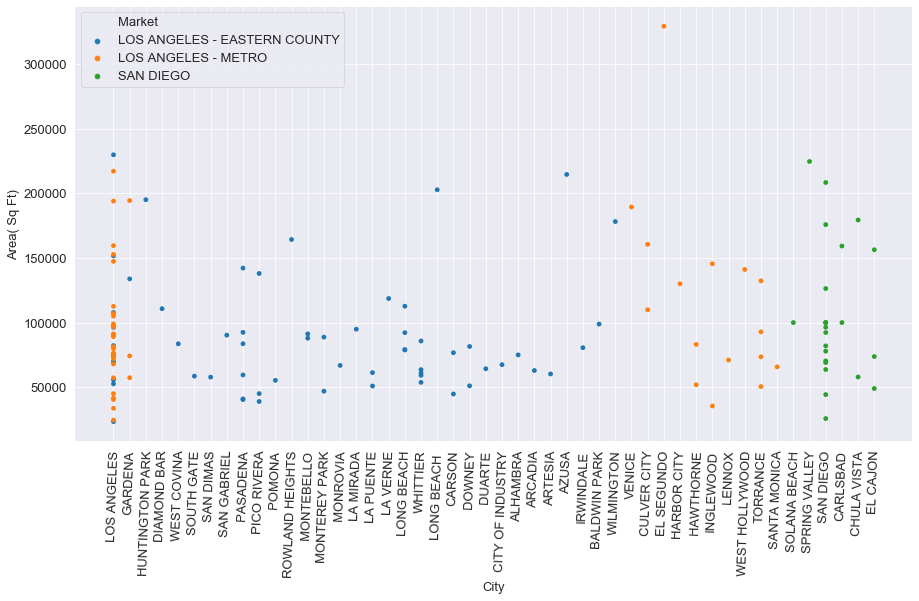

In [441]:
area_cty_plot(ps_loc[(ps_loc['Market'].str.contains('BAY')) | (ps_loc['Market'].str.contains('SAN FR'))])
area_cty_plot(ps_loc[(ps_loc['Market'].str.contains('CEN')) | (ps_loc['Market'].str.contains('SACR'))\
                     | (ps_loc['Market'].str.contains('INL'))| (ps_loc['Market'].str.contains('VEN'))])
area_cty_plot(ps_loc[(ps_loc['Market'].str.contains('LOS')) | (ps_loc['Market'].str.contains('SAN DI'))])

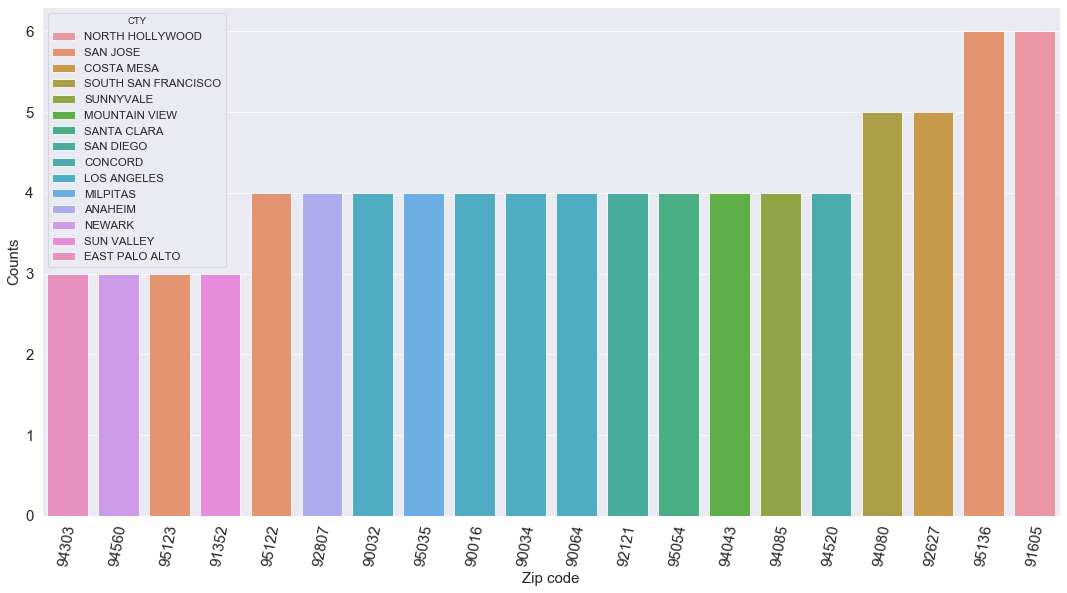

In [425]:
city_zip_plot(ps_loc)

# Make Final feature vector for Model building

In [386]:
ps_join_df = ps_join[['Zip','Area','age','edu_encode','1bed1bath','2bed1bath','res_hp_per_sqft',\
                      'res_rent_per_sqft','Feb_2021_Unemp_rate']]

# Since, most of the values are curated, take a random sample by keeping similar range of values
# so that each value is little bit different than the other to mimic real life scenario
ps_join_df['ps_rent_per_sqft'] = np.random.uniform(7.0,8.55, size=len(ps_join_df))
ps_join_df['Feb_2021_Unemp_rate'] = np.random.uniform(6.4,10.8, size=len(ps_join_df))
ps_join_df['res_rent_per_sqft'] = np.random.uniform(5.5, 8.125, size=len(ps_join_df))
ps_join_df['res_hp_per_sqft'] = np.random.uniform(400.0,590.90, size=len(ps_join_df))
ps_join_df['1bed1bath'] = np.random.uniform(2200.0,3250.00, size=len(ps_join_df))
ps_join_df['2bed1bath'] = np.random.uniform(3400.0,4750.00, size=len(ps_join_df))
ps_join_df   # Final curated dataframe

In [442]:
# We don't need zipciode as a fetaure for ML, so take all features exclusing zipcode
ml_input = ps_join_df.loc[:,'Area':] 
ml_input.columns.to_list()

['Area',
 'age',
 'edu_encode',
 '1bed1bath',
 '2bed1bath',
 'res_hp_per_sqft',
 'res_rent_per_sqft',
 'Feb_2021_Unemp_rate',
 'ps_rent_per_sqft']

# Correlation Plot

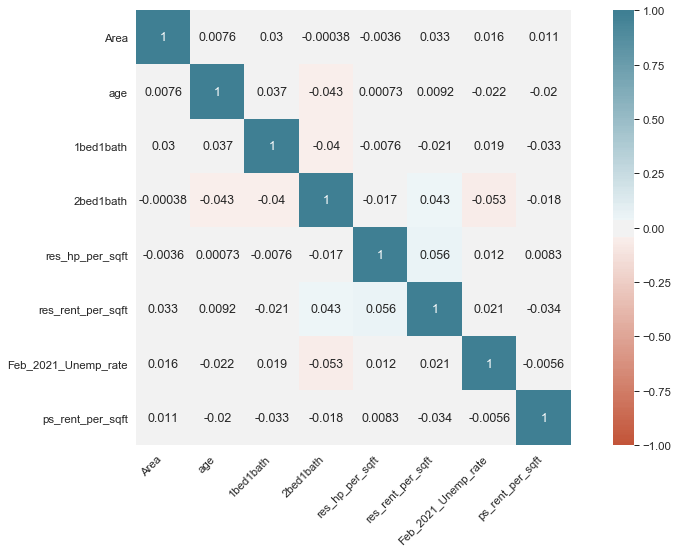

In [398]:
# Check the correlation among the features
plt.figure(figsize=(15,8))
corr = ml_input.corr()
ax = sns.heatmap(
corr, annot=True,
vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(20, 220, n=200),
square=True
)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=45,
horizontalalignment='right'
)
plt.show()

# Model building Begins

In [389]:
print(ml_input.shape)
ml_input.to_csv("test.csv", index=False) # copy the final file to a csv

(1649, 9)


In [390]:
train_path = os.path.join('.', 'test.csv') # read the file and prepare the feature numpy array
x = load_gmm_dataset(train_path)
K = 3 # Three Gaussian clusters are selected for Buy/expand or contract
NUM_TRAILS = 3

# Calculate mu, sigma and initialize the weights

In [392]:
#initialize mu and sigma by splitting the data points uniformly at random into K groups, then calculating the sample mean
# and covariance for each group
n, d = x.shape
group = np.random.choice(K, n)
mu = [np.mean(x[group == g, :], axis=0) for g in range(K)]
sigma = [np.cov(x[group == g, :].T) for g in range(K)]

#initialize phi to place equal probability on each Gaussian. Phi should be a numpy array of
# shape (K, )
phi = np.full((K,), fill_value = (1. / K), dtype=np.float32)

#initialize the w values to place equal probability on each Gaussian
# w should be a numpy array of shape (m. K)
w = np.full((n, K), fill_value = (1. / K), dtype = np.float32)
w # initial weight ( these are probabilities, the three weights add up to 1)

array([[0.33333334, 0.33333334, 0.33333334],
       [0.33333334, 0.33333334, 0.33333334],
       [0.33333334, 0.33333334, 0.33333334],
       ...,
       [0.33333334, 0.33333334, 0.33333334],
       [0.33333334, 0.33333334, 0.33333334],
       [0.33333334, 0.33333334, 0.33333334]], dtype=float32)

# Run EM algorithm and get the final weight probabilities

In [393]:
w = run_em(x, w, phi, mu, sigma) # Run EM algorithm and get the final weights or probabilities

[iter: 001, log-likelihood: -66816.5696]
[iter: 002, log-likelihood: -66814.0794]
[iter: 003, log-likelihood: -66811.3510]
[iter: 004, log-likelihood: -66807.8808]
[iter: 005, log-likelihood: -66803.2323]
[iter: 006, log-likelihood: -66796.7286]
[iter: 007, log-likelihood: -66786.8693]
[iter: 008, log-likelihood: -66769.4716]
[iter: 009, log-likelihood: -66730.0157]
[iter: 010, log-likelihood: -66601.3334]
[iter: 011, log-likelihood: -66113.9173]
[iter: 012, log-likelihood: -65704.6936]
[iter: 013, log-likelihood: -65485.9017]
[iter: 014, log-likelihood: -65360.0094]
[iter: 015, log-likelihood: -65352.7714]
[iter: 016, log-likelihood: -65349.5783]
[iter: 017, log-likelihood: -65347.2843]
[iter: 018, log-likelihood: -65345.7187]
[iter: 019, log-likelihood: -65344.5907]
[iter: 020, log-likelihood: -65343.6660]
[iter: 021, log-likelihood: -65342.7817]
[iter: 022, log-likelihood: -65341.8189]
[iter: 023, log-likelihood: -65340.6213]
[iter: 024, log-likelihood: -65338.9039]
[iter: 025, log-

In [394]:
w = pd.DataFrame(w)
w.columns=['probability_1', 'probability_2', 'probability_3'] # assign the outputs columns names
w

probability_1  probability_2  probability_3
0            0.9856         0.0000         0.0144
1            0.9930         0.0000         0.0070
2            0.9896         0.0000         0.0104
3            0.9777         0.0000         0.0223
4            0.9829         0.0000         0.0171
5            0.9861         0.0000         0.0139
6            0.9950         0.0000         0.0050
7            0.9857         0.0000         0.0143
8            0.9847         0.0000         0.0153
9            0.9919         0.0000         0.0081
10           0.9827         0.0000         0.0173
11           0.9733         0.0000         0.0267
12           0.9896         0.0000         0.0104
13           0.9587         0.0000         0.0413
14           0.9961         0.0000         0.0039
15           0.9826         0.0000         0.0174
16           0.9903         0.0000         0.0097
17           0.9979         0.0000         0.0021
18           0.9815         0.0000         0.0185
19           0.9678         0.0000         0.0322
20           0.9883         0.0000         0.0117
21           0.9909         0.0000         0.0091
22           0.9907         0.0000         0.0093
23           0.9822         0.0000         0.0178
24           0.9740         0.0000         0.0260
25           0.9739         0.0000         0.0261
26           0.9883         0.0000         0.0117
27           0.9810         0.0000         0.0190
28           0.9822         0.0000         0.0178
29           0.9838         0.0000         0.0162
30           0.9879         0.0000         0.0121
31           0.9892         0.0000         0.0108
32           0.9653         0.0000         0.0347
33           0.9942         0.0000         0.0058
34           0.9796         0.0000         0.0204
35           0.9864         0.0000         0.0136
36           0.9904         0.0000         0.0096
37           0.9906         0.0000         0.0094
38           0.9885         0.0000         0.0115
39           0.9853         0.0000         0.0147
40           0.9932         0.0000         0.0068
41           0.9950         0.0000         0.0050
42           0.9876         0.0000         0.0124
43           0.9839         0.0000         0.0161
44           0.9826         0.0000         0.0174
45           0.9812         0.0000         0.0188
46           0.9792         0.0000         0.0208
47           0.9711         0.0000         0.0289
48           0.9875         0.0000         0.0125
49           0.9801         0.0000         0.0199
50           0.9863         0.0000         0.0137
51           0.9728         0.0000         0.0272
52           0.9954         0.0000         0.0046
53           0.9803         0.0000         0.0197
54           0.9758         0.0000         0.0242
55           0.9944         0.0000         0.0056
56           0.9926         0.0000         0.0074
57           0.9971         0.0000         0.0029
58           0.9849         0.0000         0.0151
59           0.9942         0.0000         0.0058
60           0.9635         0.0000         0.0365
61           0.9696         0.0000         0.0304
62           0.9920         0.0000         0.0080
63           0.9871         0.0000         0.0129
64           0.9755         0.0000         0.0245
65           0.9873         0.0000         0.0127
66           0.9782         0.0000         0.0218
67           0.9795         0.0000         0.0205
68           0.9951         0.0000         0.0049
69           0.9873         0.0000         0.0127
70           0.9890         0.0000         0.0110
71           0.9966         0.0000         0.0034
72           0.9802         0.0000         0.0198
73           0.9798         0.0000         0.0202
74           0.9879         0.0000         0.0121
75           0.9811         0.0000         0.0189
76           0.9925         0.0000         0.0075
77           0.9928         0.0000         0.0072
78           0.9624         0.0000         0.0376
79    

# Concatenate the probabilities to the original dataset

In [395]:
ps_join_df = ps_join_df.join(w) # concatenate the probability columns to original dataframe
ps_join_df

Zip        Area  age edu_encode  1bed1bath  2bed1bath  \
0     94602  44266.0000   24          4  3015.3593  3702.6534   
1     94602  44266.0000   54          4  2365.0666  4363.3193   
2     94602  44266.0000   30          3  2948.9400  3573.6161   
3     94602  44266.0000   38          2  2999.3609  4389.5798   
4     94602  44266.0000   55          5  3174.5745  4003.0786   
5     94602  44266.0000   43          2  3012.1666  3584.8674   
6     94602  44266.0000   35          4  2857.3859  3412.9476   
7     94602  44266.0000   25          2  3173.3298  4491.1462   
8     94602  44266.0000   30          5  2986.7619  4479.3577   
9     94602  44266.0000   69          2  3182.7288  4363.7235   
10    94602  44266.0000   21          2  2328.7139  4420.8707   
11    94602  44266.0000   25          2  3227.2822  4574.0982   
12    94602  44266.0000   44          5  2210.0918  3564.0636   
13    94602  44266.0000   42          2  2244.0249  4158.1946   
14    94602  44266.0000   45          4  2295.9409  3495.4928   
15    94602  44266.0000   38          1  2895.6310  4192.9252   
16    94602  44266.0000   42          2  2943.8977  4608.4562   
17    94602  44266.0000   61          5  2364.7760  3530.1905   
18    94602  44266.0000   46          5  2654.4986  4181.6105   
19    94602  44266.0000   21          2  2923.1727  4362.8016   
20    94602  44266.0000   32          2  2762.5881  4160.5143   
21    94602  44266.0000   22          2  2382.9725  3718.9389   
22    94602  44266.0000   44          5  2872.9244  3733.4251   
23    94602  44266.0000   33          2  2825.2083  3707.8070   
24    94602  44266.0000   35          3  2775.3617  3759.8814   
25    94602  44266.0000   54          2  2839.1167  4429.0194   
26    94602  44266.0000   49          3  2270.0422  3757.6998   
27    94602  44266.0000   50          2  2255.1501  3411.8827   
28    94602  44266.0000   27          4  3189.0987  4079.0405   
29    94602  44266.0000   39          2  3124.5676  3860.9349   
30    94602  44266.0000   22          3  2569.1803  4436.7783   
31    94602  44266.0000   46          2  2839.9555  3946.0589   
32    94602  44266.0000   27          2  2636.8975  4550.8060   
33    94602  44266.0000   26          3  2209.0771  4261.4068   
34    94602  44266.0000   43          2  2432.5543  4418.6448   
35    94602  44266.0000   62          2  2739.0421  4586.9552   
36    94602  44266.0000   53          3  2272.1809  3722.9945   
37    94602  44266.0000   48          1  2825.1941  4690.4626   
38    94602  44266.0000   34          2  2649.0598  4058.1624   
39    94602  44266.0000   60          2  2552.6408  4482.1287   
40    94602  44266.0000   57          4  2993.3076  3703.3440   
41    94602  44266.0000   48          4  3141.6512  3687.9140   
42    94602  44266.0000   48          2  2685.3507  4342.0126   
43    94602  44266.0000   44          2  3064.7075  4567.5955   
44    94602  44266.0000   46          2  2642.3015  3623.0899   
45    94602  44266.0000   58          2  2616.3857  3456.1628   
46    94602  44266.0000   52          2  2613.7182  3538.2066   
47    94602  44266.0000   40          2  2554.1153  3459.6504   
48    94602  44266.0000   25          2  3223.1654  3596.4952   
49    94602  44266.0000   41          2  2418.1346  3853.4628   
50    94602  44266.0000   80          2  2980.4726  3943.7029   
51    94602  44266.0000   26          3  2792.5676  4593.2090   
52    94602  44266.0000   48          2  3235.5153  3404.2233   
53    94602  44266.0000   28          4  3221.2587  3868.0627   
54    94602  44266.0000   48          2  2766.9435  4366.6240   
55    94602  44266.0000   58          3  2454.7178  4512.0510   
56    94602  44266.0000   30          3  2894.8372  4724.2134   
57    94602  44266.0000   61          3  3221.0811  3478.7895   
58    94602  44266.0000   34          4  2551.1950  4105.2405   
59    94602  44266.0000   61          4  3129.2626  3422.9719   
60    94602  44266.0000   42          2  26

# Final Output on classification, based on a threshold assumption

1. Assume threshold epsilon= 0.8
2. if probability_1 > 0.8, we’ll consider ‘buy’
3. if probability_2 > 0.8, we’ll consider ‘expand’
4. if probability_3 > 0.8, we will consider ‘contract'.

In [443]:
ps_join_df.shape

(1649, 13)

In [462]:
# Create label based on probabilities
def label(prob1,prob2,prob3, eps):
    if prob1 >eps:
        return 'buy'
    elif prob2 >eps:
        return 'expand'
    elif prob3 >eps:
        return 'contract'
    else:
        return 'contract'
    
final_df = ps_join_df.copy()
final_df['label'] = final_df.apply(lambda x: label(x['probability_1'], x['probability_2'], x['probability_3'], 0.8), axis=1) 
final_df['label'].value_counts()

buy         964
contract    479
expand      206
Name: label, dtype: int64